In [1]:
import pandas as pd
from fastai.tabular import *

In [58]:
# Temp fix
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""


Dataset filename .csv decoding

e.g. **Faults_Cleaning_Counters_100_D_20_1.csv**

Field | Description
------|-----------------
Faults_Cleaning_Counters | what is in the datset
100 |  number of machines Serial Numbers in the datset. 
D | time period of summarization D=Days W=Weeks
10 | depth of each row in periods
1 | time periods between two consecutive rows for the same Serial Number

In [59]:
dataset_root = "Faults_Cleaning_100_D_20_1"

In [60]:
df = pd.read_csv(dataset_root+".csv",parse_dates = ['Target Timestamp'])

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62200 entries, 0 to 62199
Data columns (total 45 columns):
Unnamed: 0          62200 non-null int64
Serial              62200 non-null int64
Model               62200 non-null object
Target Timestamp    62200 non-null datetime64[ns]
CLEANING-20D        62200 non-null float64
CLEANING-19D        62200 non-null float64
CLEANING-18D        62200 non-null float64
CLEANING-17D        62200 non-null float64
CLEANING-16D        62200 non-null float64
CLEANING-15D        62200 non-null float64
CLEANING-14D        62200 non-null float64
CLEANING-13D        62200 non-null float64
CLEANING-12D        62200 non-null float64
CLEANING-11D        62200 non-null float64
CLEANING-10D        62200 non-null float64
CLEANING-9D         62200 non-null float64
CLEANING-8D         62200 non-null float64
CLEANING-7D         62200 non-null float64
CLEANING-6D         62200 non-null float64
CLEANING-5D         62200 non-null float64
CLEANING-4D         62200 non

In [62]:
categories_roots = list(set([s.split('-')[0] for s in df.columns if '-' in s]))

In [63]:
time_period=list(set([s.split('-')[1][-1] for s in df.columns if '-' in s]))[0]
time_period

'D'

In [64]:
target_width = 5

In [65]:
columns_to_sum = ['FAULT-%d%s'%(n,time_period) for n in range(target_width-1,0,-1)]
columns_to_sum.append('TARGET')
columns_to_sum

['FAULT-4D', 'FAULT-3D', 'FAULT-2D', 'FAULT-1D', 'TARGET']

In [66]:
from itertools import chain
columns_to_drop = [['%s-%d%s'%(root,n,time_period) for n in range(target_width-1,0,-1)] for root in categories_roots]
columns_to_drop = list(chain(*columns_to_drop))
columns_to_drop

['FAULT-4D',
 'FAULT-3D',
 'FAULT-2D',
 'FAULT-1D',
 'CLEANING-4D',
 'CLEANING-3D',
 'CLEANING-2D',
 'CLEANING-1D']

In [67]:
df['TARGET']=df[columns_to_sum].sum(axis=1)
# For now only boolean prediction
df['TARGET'] = (df['TARGET']>0).astype(int)


In [68]:
df['TARGET'].value_counts()

0    40860
1    21340
Name: TARGET, dtype: int64

In [69]:
df.columns

Index(['Unnamed: 0', 'Serial', 'Model', 'Target Timestamp', 'CLEANING-20D',
       'CLEANING-19D', 'CLEANING-18D', 'CLEANING-17D', 'CLEANING-16D',
       'CLEANING-15D', 'CLEANING-14D', 'CLEANING-13D', 'CLEANING-12D',
       'CLEANING-11D', 'CLEANING-10D', 'CLEANING-9D', 'CLEANING-8D',
       'CLEANING-7D', 'CLEANING-6D', 'CLEANING-5D', 'CLEANING-4D',
       'CLEANING-3D', 'CLEANING-2D', 'CLEANING-1D', 'FAULT-20D', 'FAULT-19D',
       'FAULT-18D', 'FAULT-17D', 'FAULT-16D', 'FAULT-15D', 'FAULT-14D',
       'FAULT-13D', 'FAULT-12D', 'FAULT-11D', 'FAULT-10D', 'FAULT-9D',
       'FAULT-8D', 'FAULT-7D', 'FAULT-6D', 'FAULT-5D', 'FAULT-4D', 'FAULT-3D',
       'FAULT-2D', 'FAULT-1D', 'TARGET'],
      dtype='object')

In [70]:
df['Target Timestamp'].min()
df['Target day'] = (df['Target Timestamp']-df['Target Timestamp'].min()).apply(lambda d: d.days)

In [71]:
columns_to_drop.extend(['Unnamed: 0','Target Timestamp','Serial'])
df = df.drop(columns_to_drop,axis=1)

In [72]:
df.columns

Index(['Model', 'CLEANING-20D', 'CLEANING-19D', 'CLEANING-18D', 'CLEANING-17D',
       'CLEANING-16D', 'CLEANING-15D', 'CLEANING-14D', 'CLEANING-13D',
       'CLEANING-12D', 'CLEANING-11D', 'CLEANING-10D', 'CLEANING-9D',
       'CLEANING-8D', 'CLEANING-7D', 'CLEANING-6D', 'CLEANING-5D', 'FAULT-20D',
       'FAULT-19D', 'FAULT-18D', 'FAULT-17D', 'FAULT-16D', 'FAULT-15D',
       'FAULT-14D', 'FAULT-13D', 'FAULT-12D', 'FAULT-11D', 'FAULT-10D',
       'FAULT-9D', 'FAULT-8D', 'FAULT-7D', 'FAULT-6D', 'FAULT-5D', 'TARGET',
       'Target day'],
      dtype='object')

In [73]:
cont_names = list(df.columns)
cont_names.remove('Model')
cont_names.remove('TARGET')


In [74]:
dep_var = 'TARGET'
cat_names = ['Model']
procs = [FillMissing, Categorify, Normalize]

In [75]:
train_test_ratio = .25

In [76]:
last_sample = len(df)
first_test = int(last_sample*(1 - train_test_ratio))
first_test,last_sample

(46650, 62200)

In [77]:
test = TabularList.from_df(df.iloc[first_test:last_sample].copy(), cat_names=cat_names,cont_names=cont_names)
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(first_test,last_sample)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [78]:
data.show_batch(rows=10)

Model,CLEANING-20D,CLEANING-19D,CLEANING-18D,CLEANING-17D,CLEANING-16D,CLEANING-15D,CLEANING-14D,CLEANING-13D,CLEANING-12D,CLEANING-11D,CLEANING-10D,CLEANING-9D,CLEANING-8D,CLEANING-7D,CLEANING-6D,CLEANING-5D,FAULT-20D,FAULT-19D,FAULT-18D,FAULT-17D,FAULT-16D,FAULT-15D,FAULT-14D,FAULT-13D,FAULT-12D,FAULT-11D,FAULT-10D,FAULT-9D,FAULT-8D,FAULT-7D,FAULT-6D,FAULT-5D,Target day,target
model 13,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,0.1555,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,-0.0740,-0.0741,-0.0744,-0.0745,-0.0193,-0.0466,0.2250,-0.0468,-0.0741,-0.0743,-0.0744,-0.0746,-0.0747,-0.0748,-0.0749,-0.0479,0.1726,1
model 13,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,0.1553,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,0.3177,0.2896,0.2604,0.1765,0.3340,0.3610,0.3609,0.3336,0.2791,0.2518,0.2245,0.1428,0.3601,0.3599,0.3054,0.0880,1.5909,1
model 20,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,0.3457,0.0098,0.2604,0.3160,0.3340,0.2251,0.3881,-0.0468,0.0074,0.3062,1.0940,0.4145,0.6590,0.4414,0.0066,0.1151,1.3236,1
model 13,0.3818,0.1645,0.1644,0.1644,-0.0529,0.1557,0.1555,-0.0526,0.1553,0.1552,-0.0529,0.1549,-0.0478,0.2939,0.4645,0.1229,-0.0740,-0.0462,-0.0186,-0.0745,-0.0465,-0.0738,-0.0467,-0.0740,-0.0198,-0.0743,-0.0744,-0.0474,-0.0747,-0.0748,-0.0749,-0.0750,1.6652,1
model 13,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,-0.0740,-0.0741,-0.0744,-0.0745,-0.0737,-0.0738,-0.0739,-0.0740,-0.0741,-0.0743,-0.0744,-0.0746,-0.0747,-0.0748,-0.0749,-0.0750,-1.2382,0
model 20,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,-0.0740,-0.0741,-0.0744,-0.0745,-0.0737,-0.0738,-0.0739,-0.0740,-0.0741,-0.0743,-0.0744,-0.0746,-0.0747,-0.0748,-0.0749,-0.0750,-1.2902,0
model 16,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,-0.0740,-0.0741,-0.0744,-0.0745,-0.0737,-0.0738,-0.0739,-0.0740,-0.0741,-0.0743,-0.0744,-0.0746,-0.0747,-0.0748,-0.0749,-0.0750,-1.2605,0
model 20,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,-0.0740,-0.0741,-0.0744,-0.0745,-0.0737,-0.0738,-0.0739,-0.0740,-0.0741,-0.0743,-0.0744,-0.0746,-0.0747,-0.0748,-0.0749,-0.0750,0.0019,0
model 10,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,-0.0740,-0.0741,-0.0744,-0.0745,-0.0737,-0.0738,-0.0739,-0.0740,-0.0741,-0.0743,-0.0744,-0.0746,-0.0747,-0.0748,-0.0749,-0.0750,-1.4164,0
model 13,-0.0526,-0.0527,-0.0528,-0.0528,-0.0529,-0.0523,-0.0525,-0.0526,-0.0527,-0.0528,-0.0529,-0.0531,-0.0478,-0.0476,-0.0477,-0.0479,-0.0740,-0.0741,-0.0744,-0.0745,-0.0737,-0.0738,-0.0739,-0.0740,-0.0741,-0.0743,-0.0744,-0.0746,-0.0747,-0.0748,-0.0749,-0.0750,0.1875,0


In [128]:
torch.manual_seed(7)

In [129]:
learn = tabular_learner(data, layers=[500,200], metrics=accuracy,wd=0.05)

In [130]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.283017,0.798020,0.613891


In [131]:
learn.save(dataset_root + '_acc_0613.learner')

In [132]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


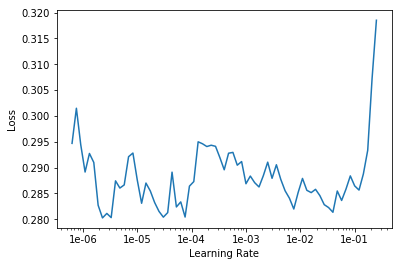

In [133]:
learn.recorder.plot()


In [134]:
learn.fit(5, 3e-2)

epoch,train_loss,valid_loss,accuracy
1,0.287843,0.938600,0.543408
2,0.279527,0.931317,0.570675
3,0.283542,5.420391,0.565852
4,0.307388,47.228859,0.546560
5,0.289531,1.738576,0.565145


In [135]:
learn.fit(10, 2e-6)

epoch,train_loss,valid_loss,accuracy
1,0.277979,14.109609,0.571897
2,0.266425,14.948373,0.565659
3,0.282477,1.817600,0.567717
4,0.290311,4.122257,0.565016
5,0.281352,3.320585,0.569003
6,0.275760,1.869172,0.562444
7,0.276828,2.945632,0.566817
8,0.295078,6.612245,0.566881
9,0.283026,8.284439,0.566302
10,0.268709,4.007000,0.565788


### Utility - split the datset

In [26]:
#
# Split the dataset in smaller chunks to allow upload to gisthub
#
df = pd.read_csv("Faults_Cleaning_Counters_100_D_20_1.csv",parse_dates = ['Target Timestamp'])
n = 4
split = len(df)/n
name = "Faults_Cleaning_Counters_100_D_20_1.csv"

for i,start_idx in enumerate(range(0,l,int(len(df)/n))):
    stop_idx = min(start_idx+int(len(df)/n),len(df))
    print(start_idx,stop_idx)
    file = "%s_%04d.csv"%(name.split('.')[0],i)
    print(file)
    df.iloc[start_idx:stop_idx].to_csv(file)

0 15575
Faults_Cleaning_Counters_100_D_20_1_0000.csv
15575 31150
Faults_Cleaning_Counters_100_D_20_1_0001.csv
31150 46725
Faults_Cleaning_Counters_100_D_20_1_0002.csv
46725 62300
Faults_Cleaning_Counters_100_D_20_1_0003.csv
